#### Nine cells signature matrix
1. Neutrophils
2. Monocytes
3. B cells
4. CD8 T cells
5. CD4 T cells
6. NK cells
7. Eosinophils
8. Basophils
9. Kupffer

In [1]:
Base_dir = 'C:/github/LiverDeconv' # cloning repository

import sys
sys.path.append(Base_dir)
import liver_deconv

import pandas as pd

***
#### Reference preparation

(11588, 57)
(51463, 84)
log2 conversion
quantile normalization
drop nan
narrowd gene number : 11553
not enough genes picked up
not enough genes picked up
signature genes : 433


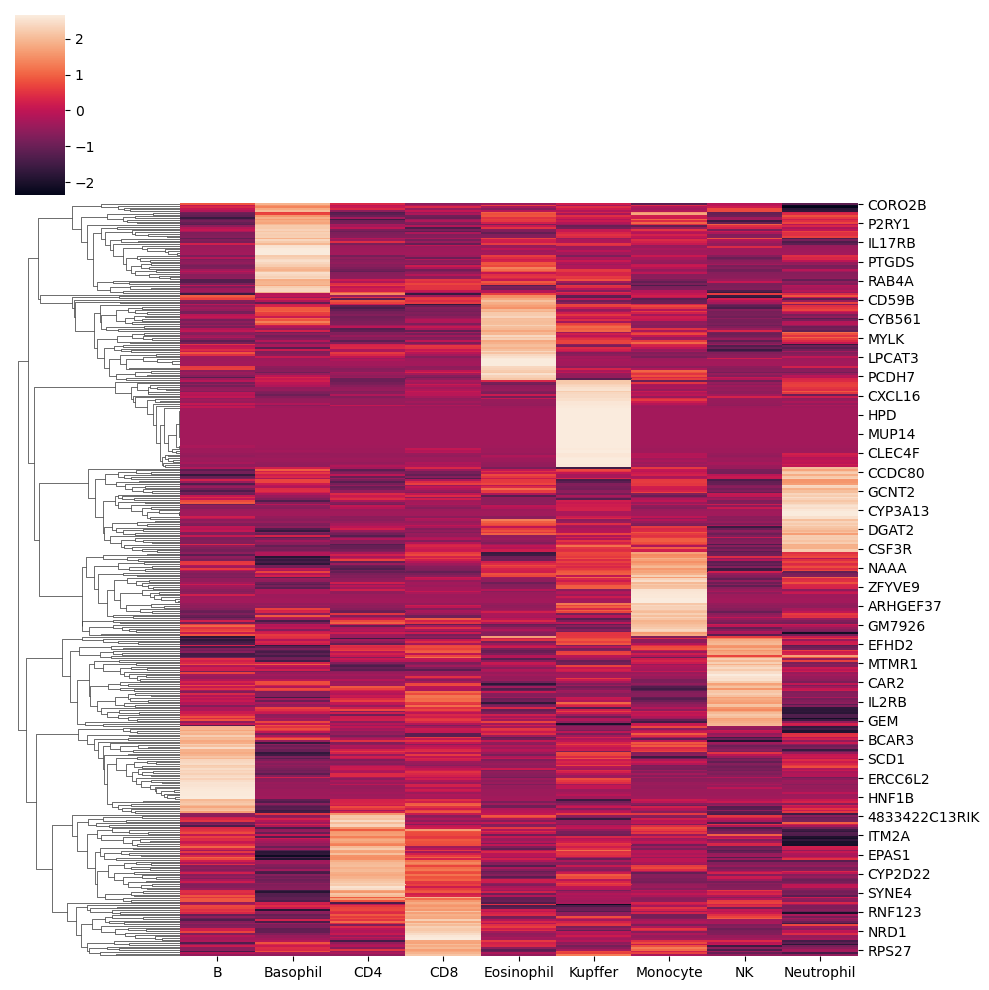

(433, 9)


,B,Basophil,CD4,CD8,Eosinophil,Kupffer,Monocyte,NK,Neutrophil
1700025G04RIK,2.734107,3.473094,7.557750,8.636027,7.009849,6.305772,8.569203,10.634596,3.987429
1810014B01RIK,7.004445,9.541214,6.350460,7.005409,5.365754,7.173600,5.676584,6.464166,0.000000
4732419C18RIK,0.000000,0.000000,0.000000,0.000000,0.000000,0.101885,2.340717,0.000000,0.000000
4732465J04RIK,0.000000,0.000000,1.746450,0.307984,1.530357,2.095494,0.000000,0.000000,8.686170
4833422C13RIK,0.000000,0.000000,3.736582,0.000000,2.031005,0.136611,0.000000,1.584739,0.000000


In [2]:
# load data
df_mix = pd.read_csv(Base_dir+'/data/processed/mix_processed.csv',index_col=0)
df_all = pd.read_csv(Base_dir+'/data/processed/ref_13types.csv',index_col=0)

target_cells = ["Neutrophil","Monocyte","B","CD8","CD4","NK","Eosinophil","Basophil","Kupffer"]
use_samples = []
for t in df_all.columns.tolist():
    if t.split("_")[0] in target_cells:
        use_samples.append(t)
df_target = df_all[use_samples]


dat = liver_deconv.LiverDeconv()
dat.set_data(df_mix=df_mix, df_all=df_target)
dat.pre_processing(do_ann=False,ann_df=None,do_log2=True,do_quantile=True,do_trimming=False,do_drop=True)
dat.narrow_intersec()
dat.create_ref(sep="_",number=50,limit_CV=10,limit_FC=1.5,log2=False,verbose=True,do_plot=True)

final_ref = dat.final_ref
print(final_ref.shape)
final_ref.head()

***
#### 2. Conduct deconvolution with Elastic Net

0 rows are removed
0 rows are removed
number of used genes = 433
fitting method : ElasticNet


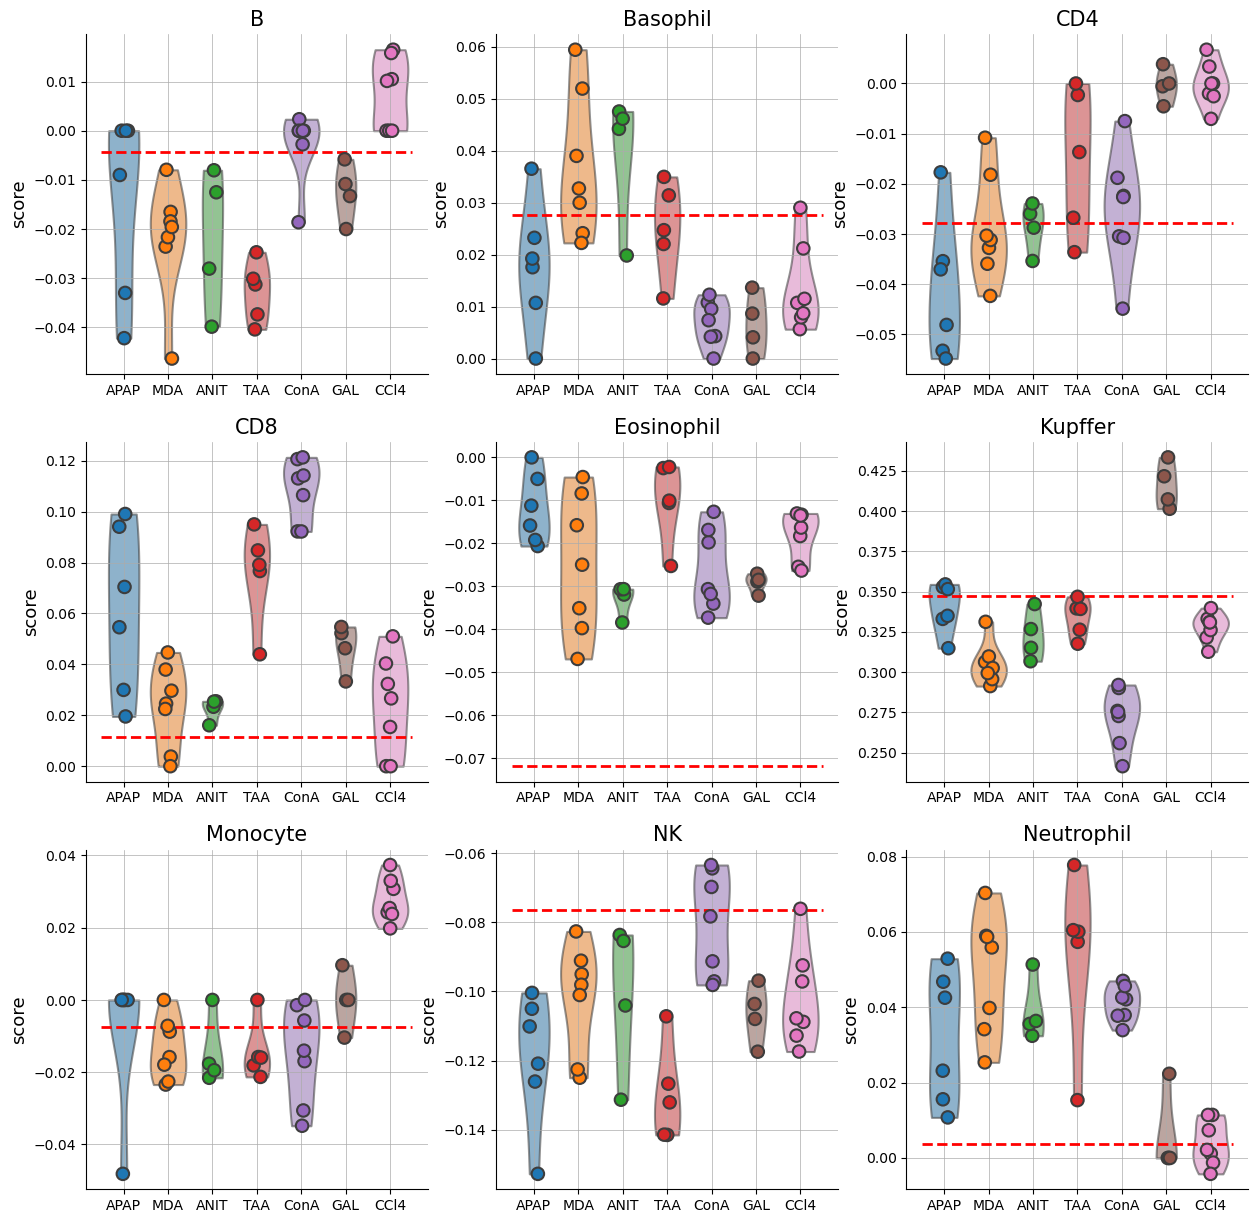

In [3]:
dat.do_fit()
dat.summarize(remove_list=["CIV_7","CIV_8","CIP_7","CIP_8"],
                  sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4"],
                  x_doc="",y_doc="score",ctrl="Ctrl",row_n=3,col_n=3,z_score=False)
res = dat.get_res()

***
#### 3. Validation

standardz population control
original : 57
after removing : 53
standardz population control
----------


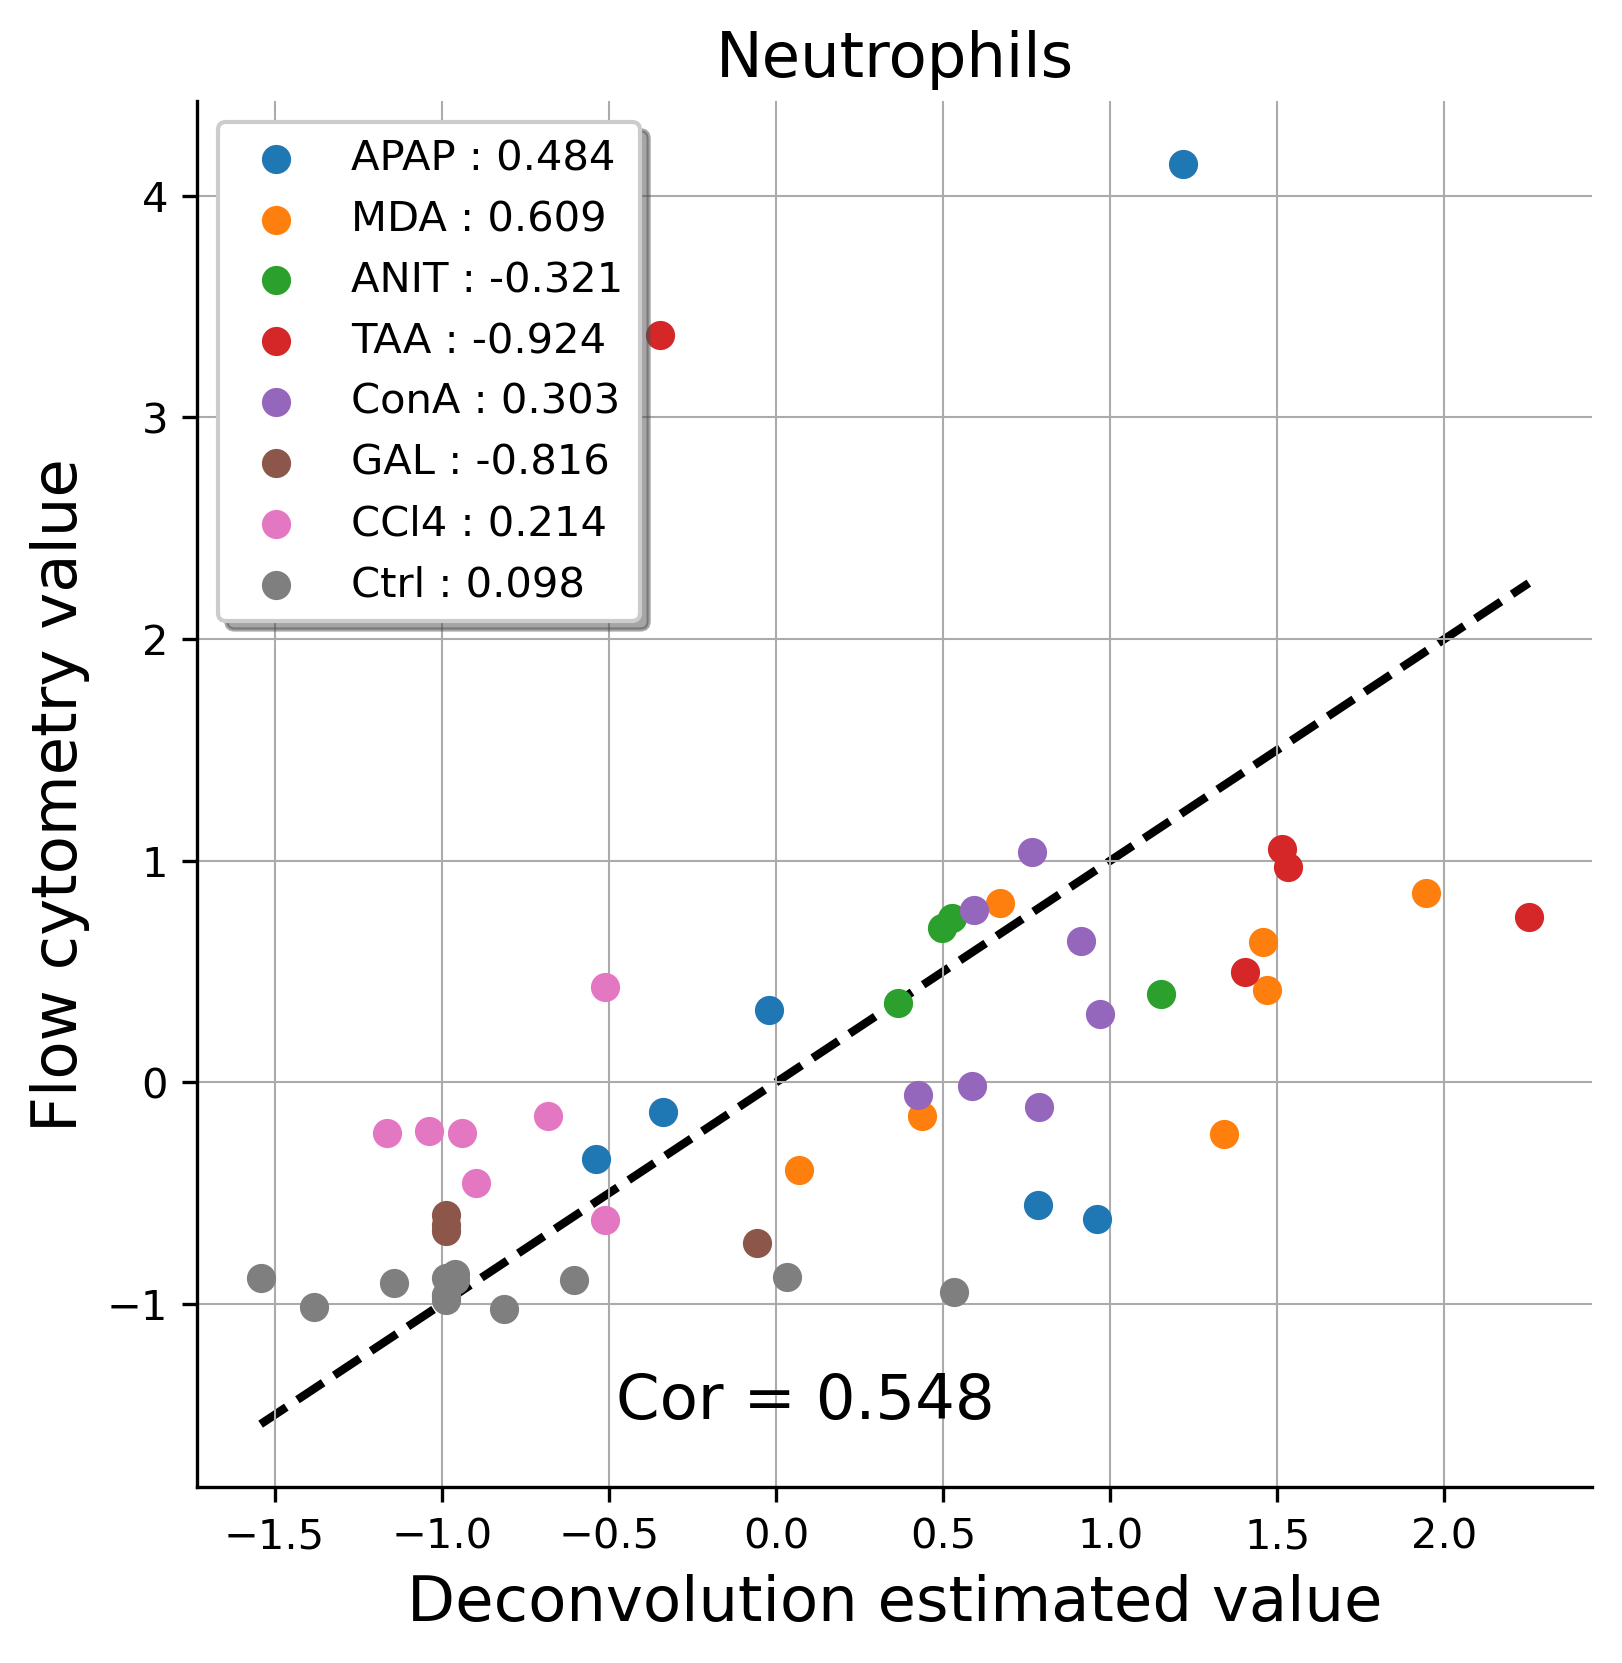

----------


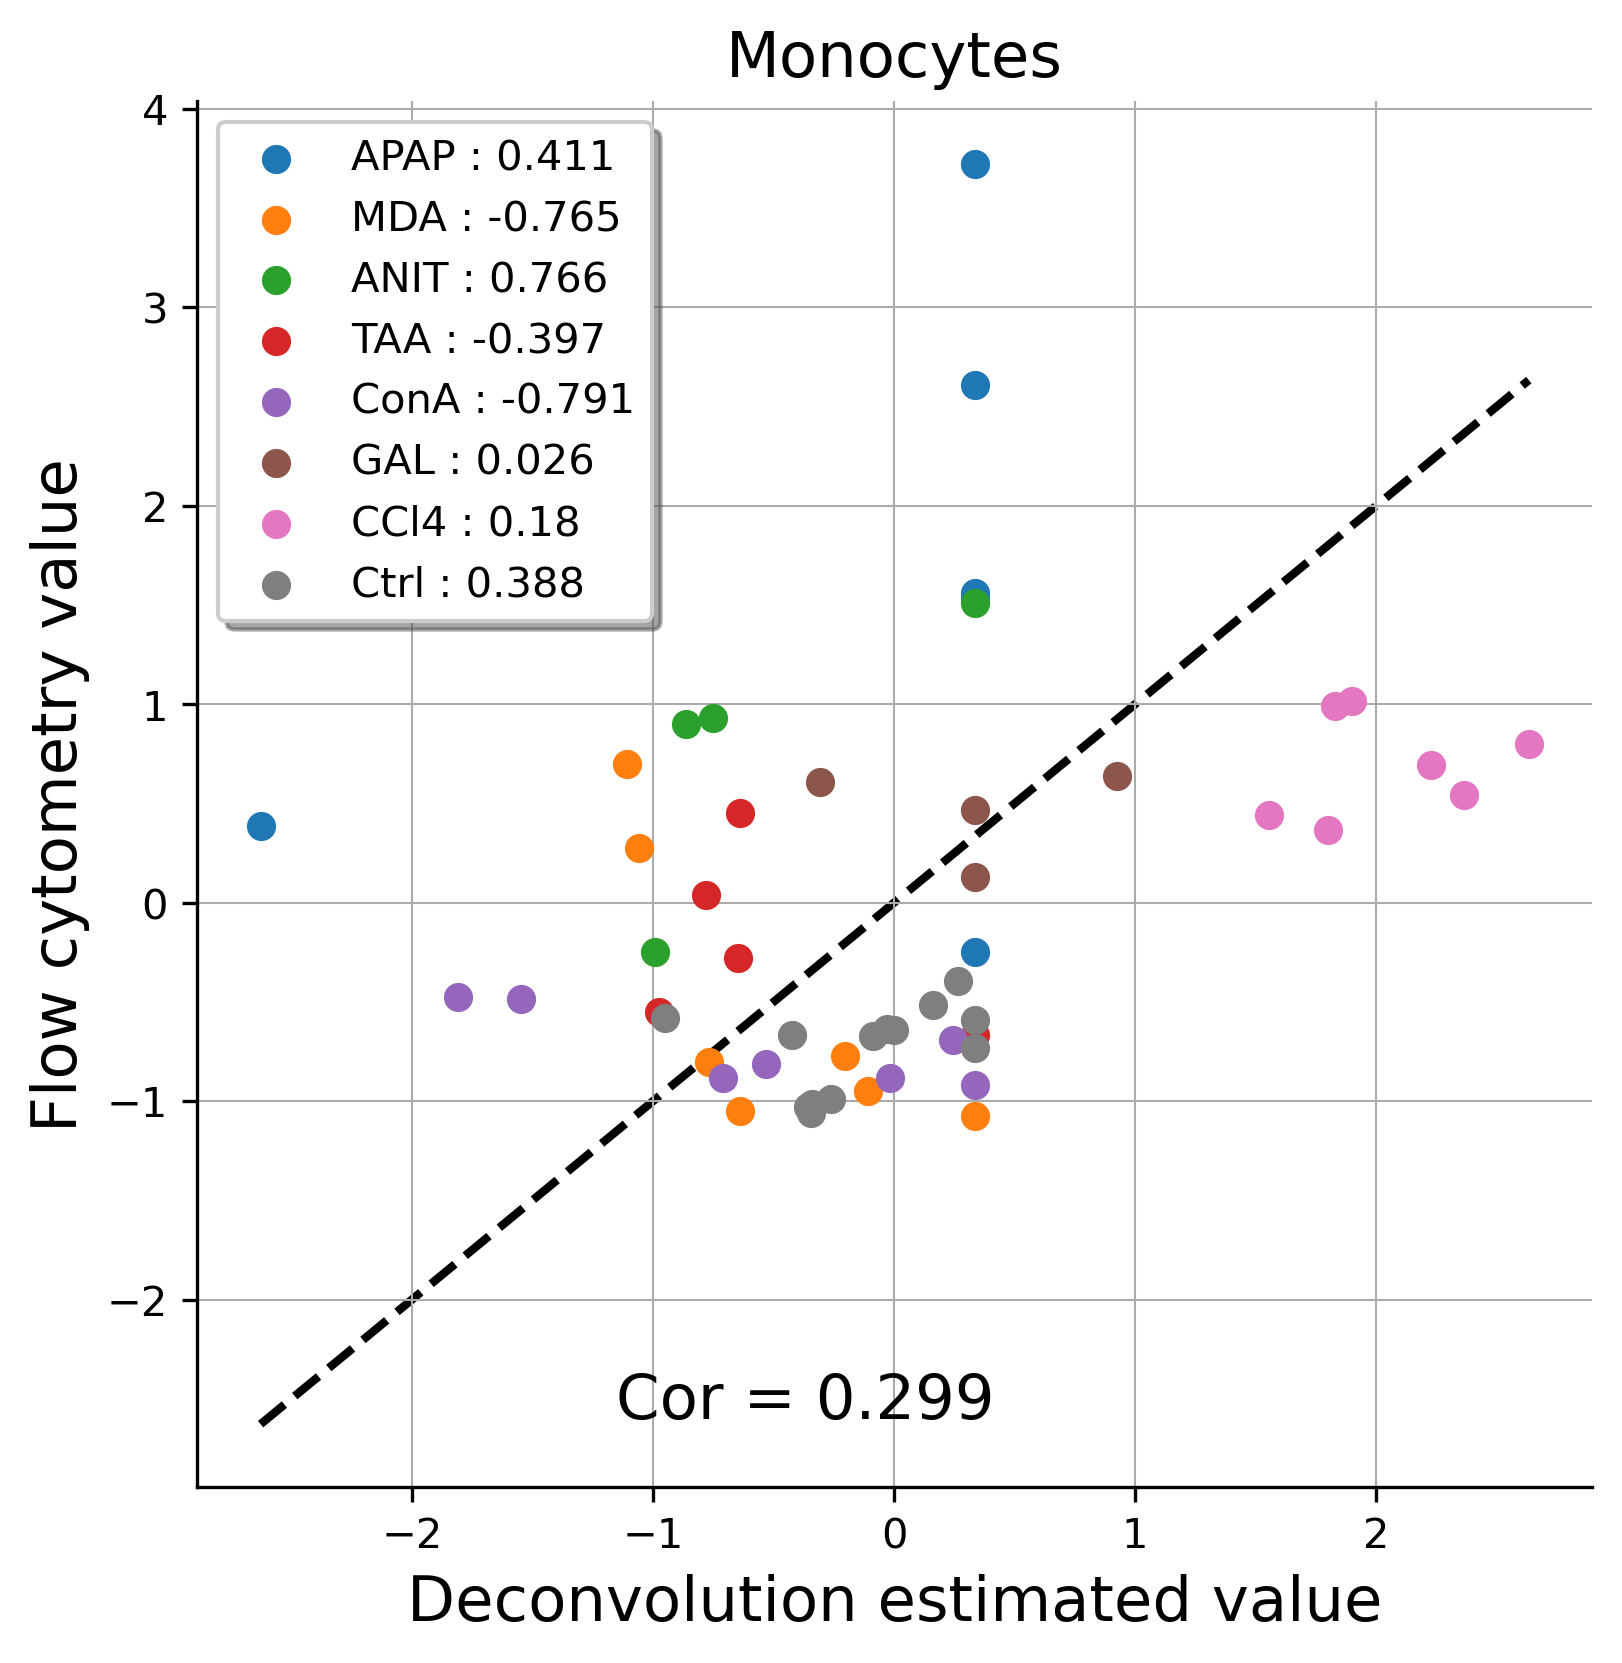

----------


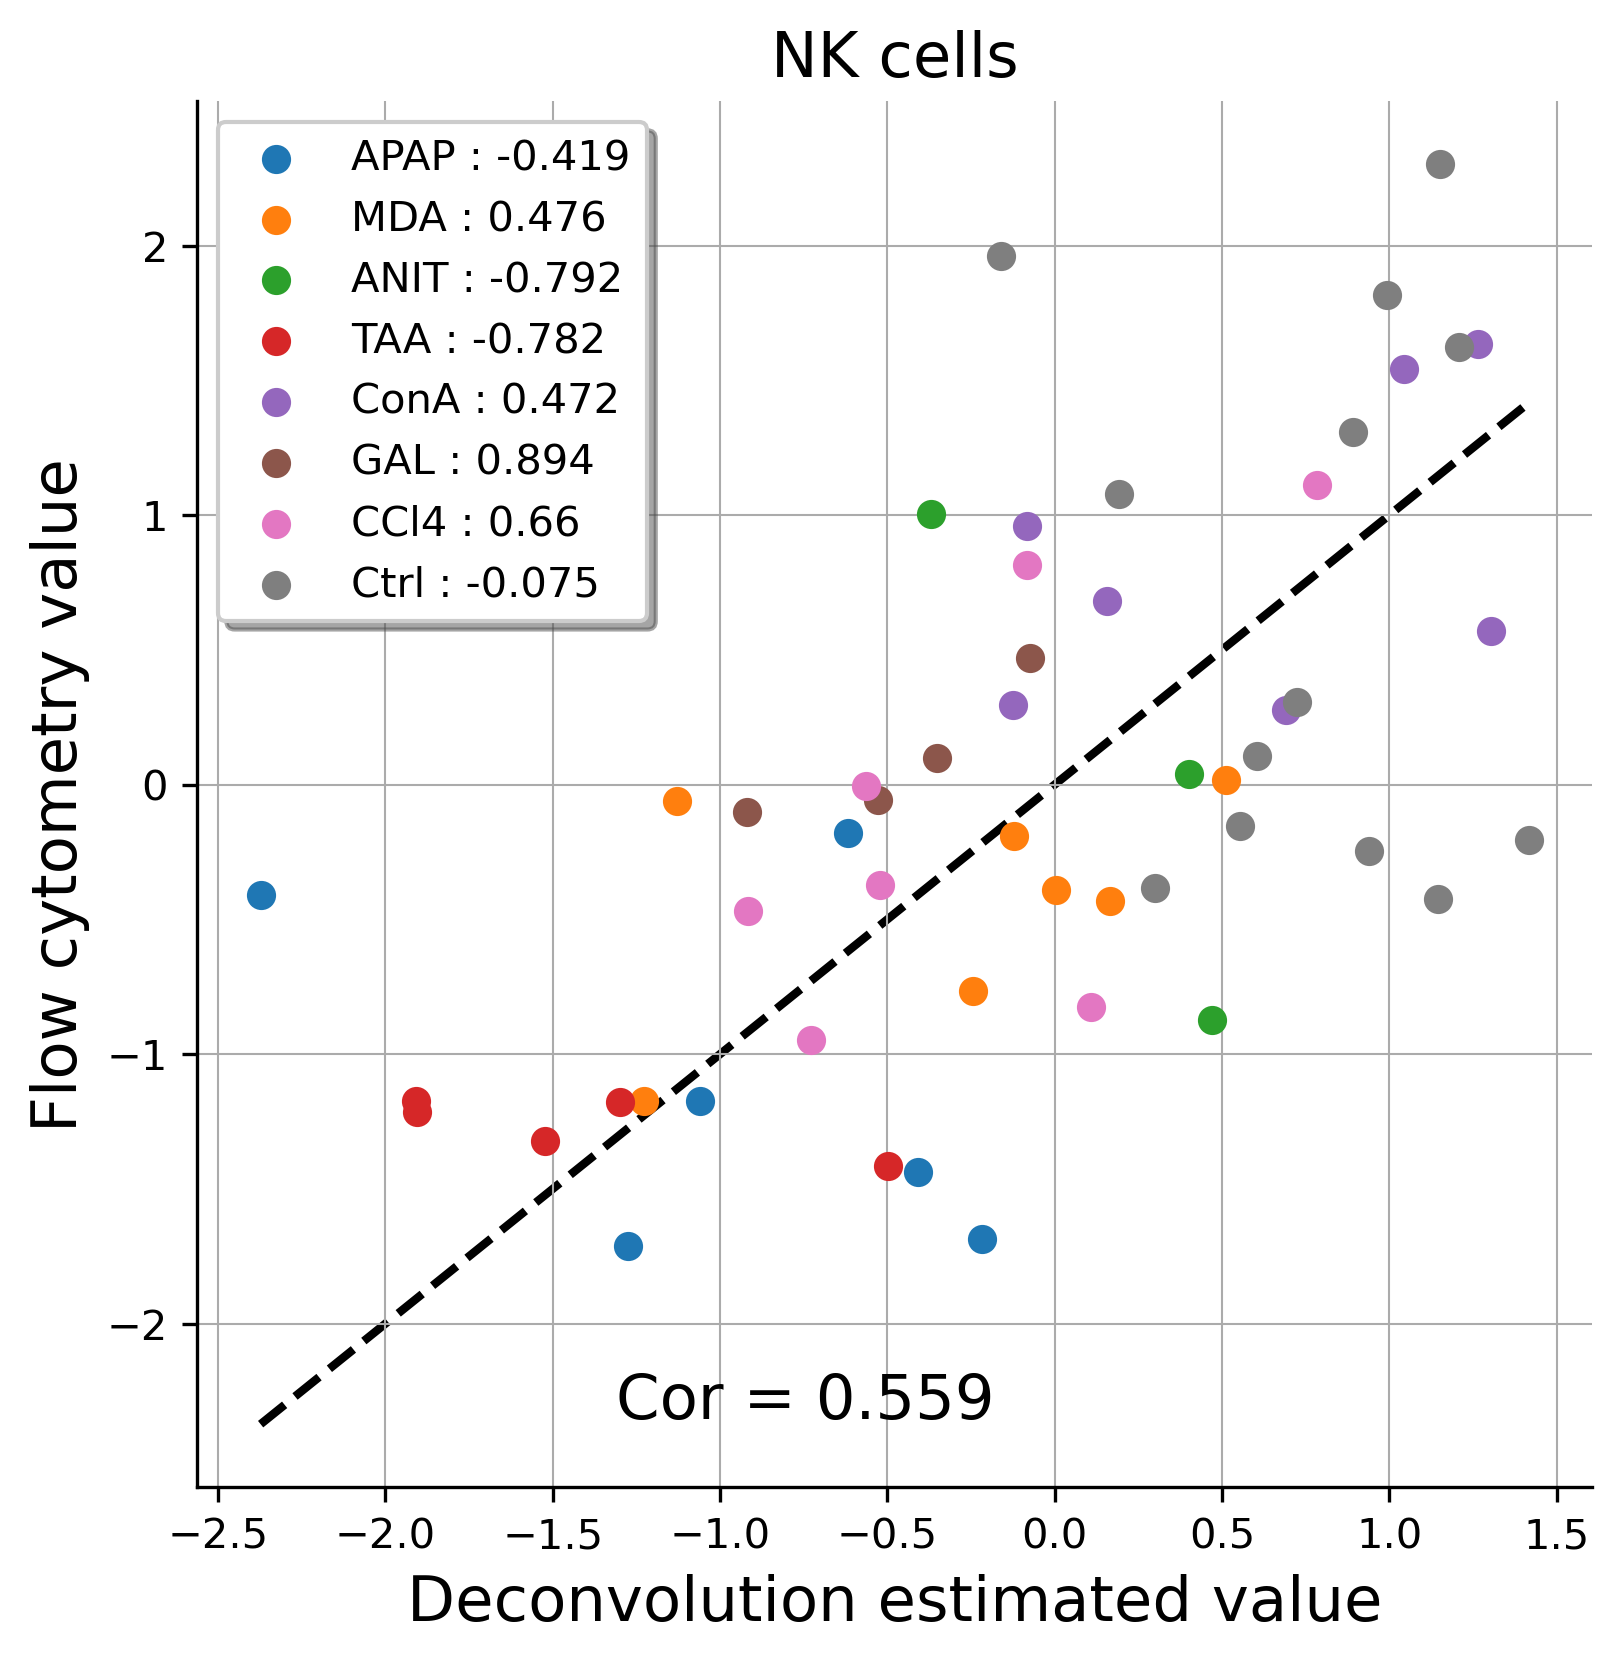

----------


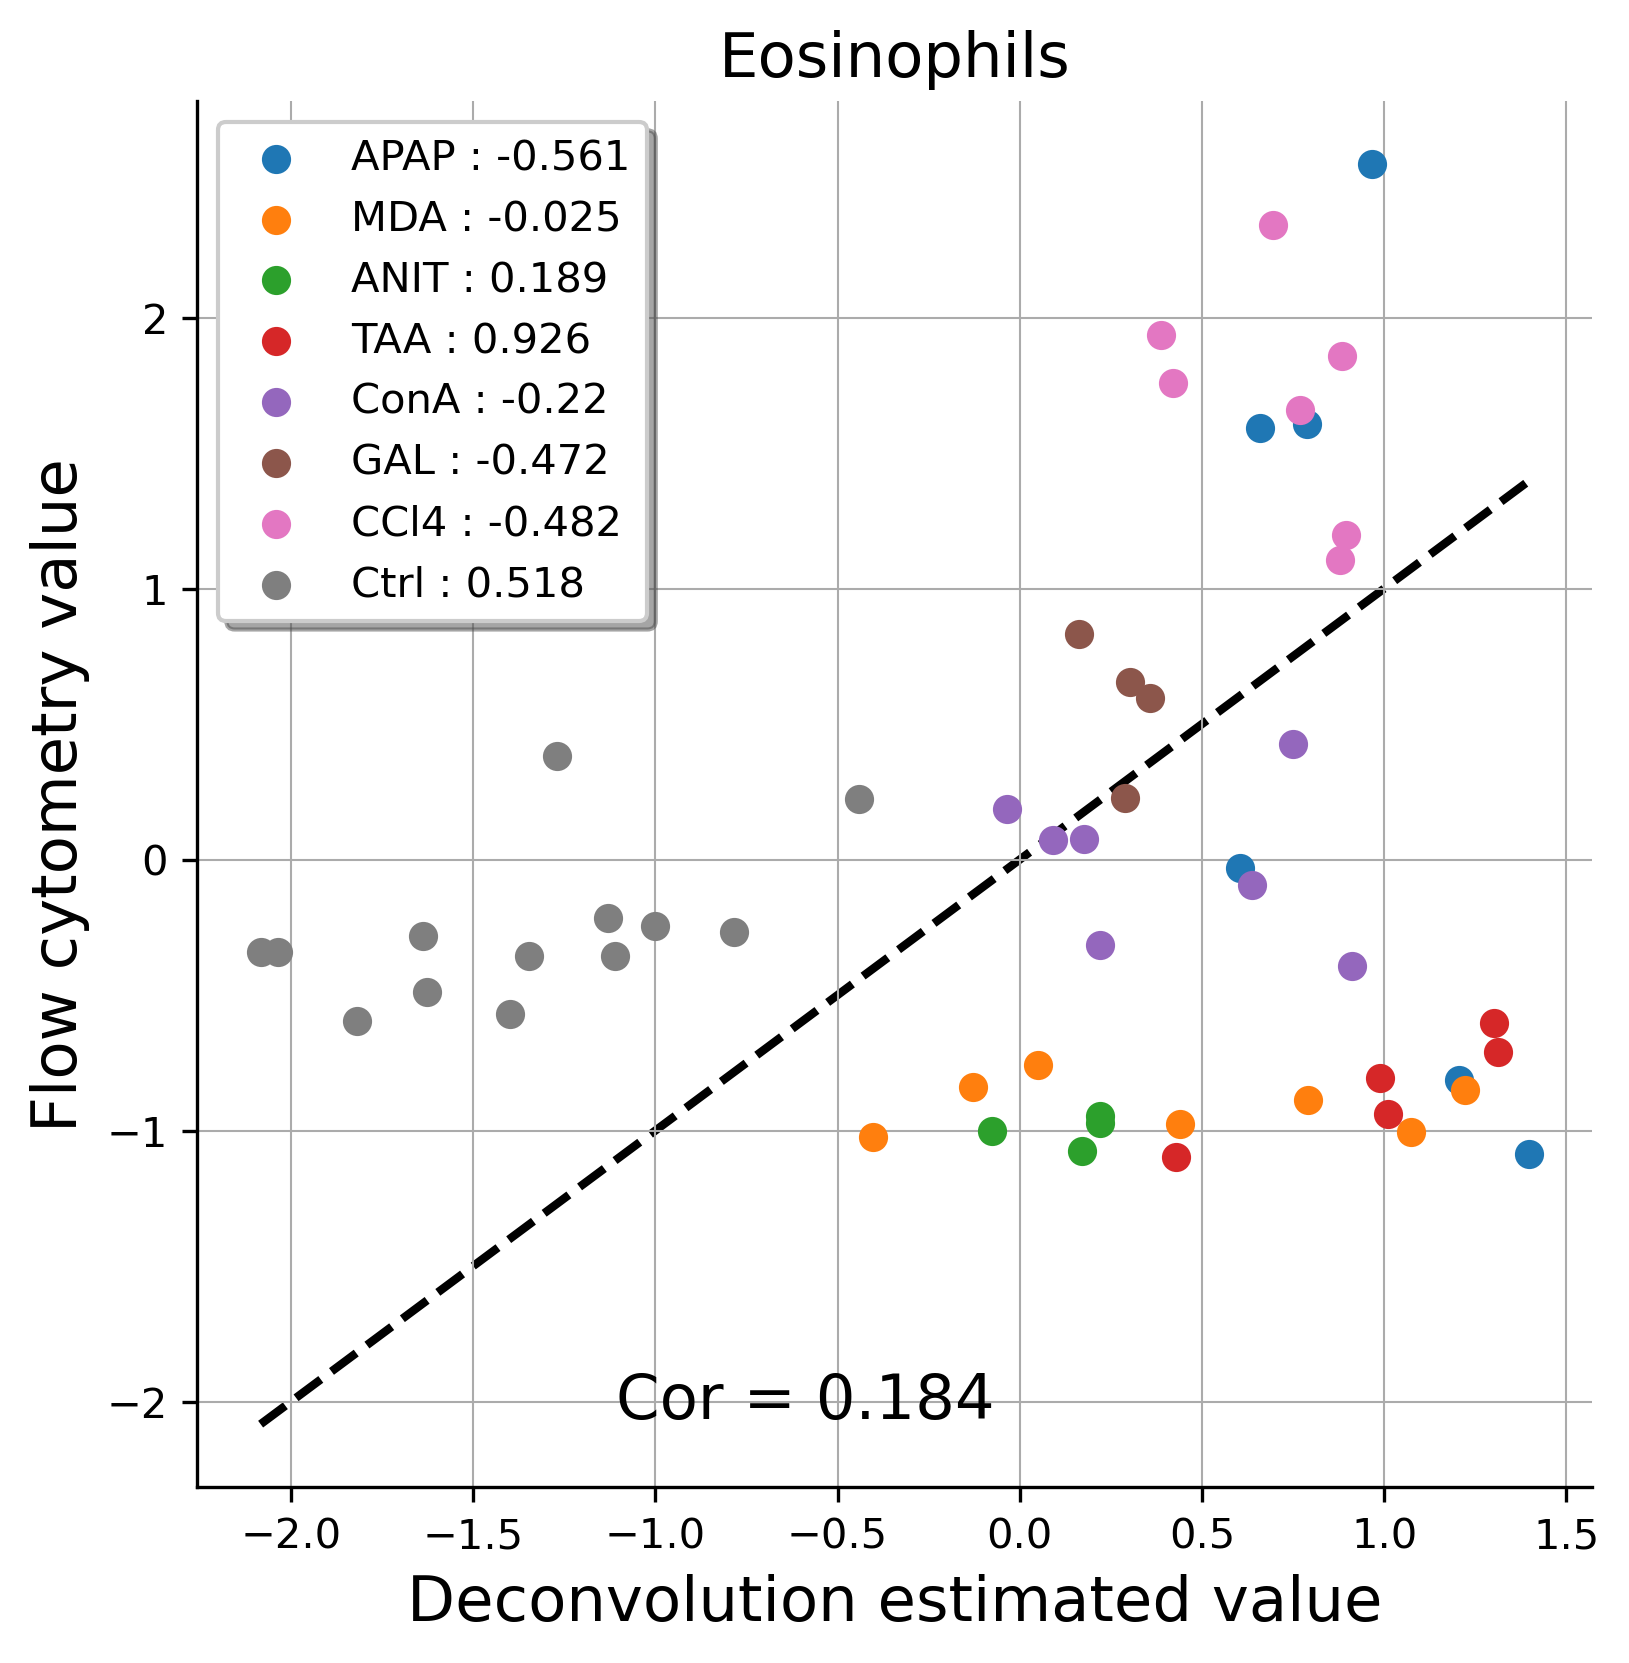

In [4]:
from Evaluation import evaluator

val_df = pd.read_csv('C:/github/LiverDeconv/Data/processed/facs_true_population.csv',index_col=0)

ev = evaluator.Evaluator()
ev.set_deconv_res(res_df=res,z_score=True)
ev.remove_samples(remove_list=["CIV_7","CIV_8","CIP_7","CIP_8"])
ev.set_validation_ref(val_df=val_df)
ev.process_validation_ref(z_score=True)

ev.evaluate(dec_names=[["Neutrophil"]],
            val_names=[["Neutrophil"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="Neutrophils",do_plot=True,simple=False,eval_all=False,dpi=300)
ev.evaluate(dec_names=[["Monocyte"]],
            val_names=[["Monocyte"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="Monocytes",do_plot=True,simple=False,eval_all=False,dpi=300)
ev.evaluate(dec_names=[["NK"]],
            val_names=[["NK"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="NK cells",do_plot=True,simple=False,eval_all=False,dpi=300)
ev.evaluate(dec_names=[["Eosinophil"]],
            val_names=[["Eosinophil"]],sort_index=["APAP","MDA","ANIT","TAA","ConA","GAL","CCl4","Ctrl"],title="Eosinophils",do_plot=True,simple=False,eval_all=False,dpi=300)

***
#### 4. Summary
- Neutrophil : 0.548
- Monocyte : 0.299
- NK : 0.559
- Eosinophil : 0.184